<a href="https://colab.research.google.com/github/JoDeMiro/Micado-Research/blob/main/03_Partial_Dependence_and_Individual_Conditional_Expectation_Plots_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Megjegyzés

Azt hiszem itt az a lényeg, hogy van egy olyan metodus ami képes arra, hogy egyenként egy egy változót a modelből eltávolítva megvizsgálja azt, hogy a változó nélkül, hogy teljesít a modell.

###https://scikit-learn.org/stable/auto_examples/inspection/plot_partial_dependence.html#

# Partial Dependence and Individual Conditional Expectation Plots

Partial dependence plots show the dependence between the target function [[2]](#2) and a set of features of interest, marginalizing over the values of all other features (the complement features). Due to the limits of human perception, the size of the set of features of interest must be small (usually, one or two) thus they are usually chosen among the most important features.

imilarly, an individual conditional expectation (ICE) plot [[3]](#3) shows the dependence between the target function and a feature of interest. However, unlike partial dependence plots, which show the average effect of the features of interest, ICE plots visualize the dependence of the prediction on a feature for each sample separately, with one line per sample. Only one feature of interest is supported for ICE plots.

This example shows how to obtain partial dependence and ICE plots from a [MLPRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor) and a [HistGradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html#sklearn.ensemble.HistGradientBoostingRegressor) trained on the California housing dataset. The example is taken from 1.


<a name="1"></a>
[1] T. Hastie, R. Tibshirani and J. Friedman, “Elements of Statistical Learning Ed. 2”, Springer, 2009.

<a name="2"></a>
[2] For classification you can think of it as the regression score before the link function.

<a name="3"></a>
[3] Goldstein, A., Kapelner, A., Bleich, J., and Pitkin, E., Peeking Inside the Black Box: Visualizing Statistical Learning With Plots of Individual Conditional Expectation. (2015) Journal of Computational and Graphical Statistics, 24(1): 44-65 (https://arxiv.org/abs/1309.6392)

# Micado Example

Center target to avoid gradient boosting init bias: gradient boosting with the ‘recursion’ method does not account for the initial estimator (here the average target, by default).

In [1]:
!pip install scikit-learn==0.24.2

     |████████████████████████████████| 22.3 MB 36 kB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [2]:
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [3]:
!wget https://raw.githubusercontent.com/JoDeMiro/Data/main/Micado/nn_training_data.csv

--2021-07-23 20:57:02--  https://raw.githubusercontent.com/JoDeMiro/Data/main/Micado/nn_training_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 156914 (153K) [text/plain]
Saving to: ‘nn_training_data.csv’

nn_training_data.cs 100%[===================>] 153.24K  --.-KB/s    in 0.03s   

2021-07-23 20:57:02 (5.01 MB/s) - ‘nn_training_data.csv’ saved [156914/156914]



In [4]:
df = pd.read_csv('nn_training_data.csv')

In [5]:
df.head()

,timestamp,PktIn,KBIn,AVG_RR,Inter,CTXSW,KBOut,CPU,SUM_RR,PktOut,vm_number,AVG_LAT_05
0,1571923606,0.291658,0.029784,16.015706,5921.905442,3359.291450,0.439268,53.500884,64.076662,0.241660,5,466.25
1,1571923621,0.300010,0.030584,17.872610,5831.266601,3273.530409,0.440144,54.386839,71.507123,0.250011,5,457.25
2,1571923637,0.275005,0.029102,17.781137,5744.585008,3250.338397,0.443237,52.858070,71.124548,0.291673,5,433.25
3,1571923652,0.275002,0.029330,17.768750,5920.160015,3296.357451,0.440507,51.445648,71.075000,0.241668,5,410.25
4,1571923683,0.300004,0.030583,17.893865,6047.794644,3333.359290,0.440620,53.043713,71.575458,0.250001,5,429.25


In [24]:
X = df[['PktIn', 'KBIn', 'AVG_RR', 'Inter', 'CTXSW', 'CPU']]

X.head()

,PktIn,KBIn,AVG_RR,Inter,CTXSW,CPU
0,0.291658,0.029784,16.015706,5921.905442,3359.291450,53.500884
1,0.300010,0.030584,17.872610,5831.266601,3273.530409,54.386839
2,0.275005,0.029102,17.781137,5744.585008,3250.338397,52.858070
3,0.275002,0.029330,17.768750,5920.160015,3296.357451,51.445648
4,0.300004,0.030583,17.893865,6047.794644,3333.359290,53.043713


In [25]:
X.describe()

,PktIn,KBIn,AVG_RR,Inter,CTXSW,CPU
count,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000
mean,0.281103,0.029469,15.040358,4780.157328,3095.583565,37.262589
std,0.016246,0.000835,6.940871,1782.942636,1076.489579,14.487499
min,0.249979,0.028026,0.000000,552.975000,1151.625000,1.937500
25%,0.270006,0.028918,10.342845,3673.845000,2470.325207,31.551272
50%,0.280000,0.029394,16.099732,5069.877825,3082.632222,39.951490
75%,0.290059,0.029958,21.338542,6285.160916,3545.723749,47.989894
max,0.400004,0.036263,23.500000,8621.316667,10181.769327,69.287500


In [26]:
X.columns

Index(['PktIn', 'KBIn', 'AVG_RR', 'Inter', 'CTXSW', 'CPU'], dtype='object')

In [27]:
y = df.AVG_LAT_05

In [28]:
print(type(y))
print(y.shape)
print(y.dtype)
print(y.min())
print(y.max())

<class 'pandas.core.series.Series'>
(900,)
float64
-241.76424206349193
627.2357579365081


In [29]:
y -= y.mean()

In [30]:
print(y.min())
print(y.max())

-241.76424206349174
627.2357579365083


In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=0
)

# 1-way partial dependence with different models

In this section, we will compute 1-way partial dependence with two different machine-learning models: (i) a multi-layer perceptron and (ii) a gradient-boosting. With these two models, we illustrate how to compute and interpret both partial dependence plot (PDP) and individual conditional expectation (ICE).

## Multi-layer perceptron
Let’s fit a [MLPRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html) and compute single-variable partial dependence plots.

In [32]:
from time import time
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import QuantileTransformer
from sklearn.neural_network import MLPRegressor

print("Training MLPRegressor...")
tic = time()
est = make_pipeline(QuantileTransformer(),
                    MLPRegressor(hidden_layer_sizes=(50, 50),
                                 learning_rate_init=0.01,
                                 early_stopping=True))
est.fit(X_train, y_train)
print(f"done in {time() - tic:.3f}s")
print(f"Test R2 score: {est.score(X_test, y_test):.2f}")

Training MLPRegressor...
done in 0.633s
Test R2 score: 0.56


We configured a pipeline to scale the numerical input features and tuned the neural network size and learning rate to get a reasonable compromise between training time and predictive performance on a test set.

Importantly, this tabular dataset has very different dynamic ranges for its features. Neural networks tend to be very sensitive to features with varying scales and forgetting to preprocess the numeric feature would lead to a very poor model.

It would be possible to get even higher predictive performance with a larger neural network but the training would also be significantly more expensive.

Note that it is important to check that the model is accurate enough on a test set before plotting the partial dependence since there would be little use in explaining the impact of a given feature on the prediction function of a poor model.

We will plot the partial dependence, both individual (ICE) and averaged one (PDP). We limit to only 50 ICE curves to not overcrowd the plot.

In [33]:
X.columns

Index(['PktIn', 'KBIn', 'AVG_RR', 'Inter', 'CTXSW', 'CPU'], dtype='object')

Computing partial dependence plots...
done in 3.295s


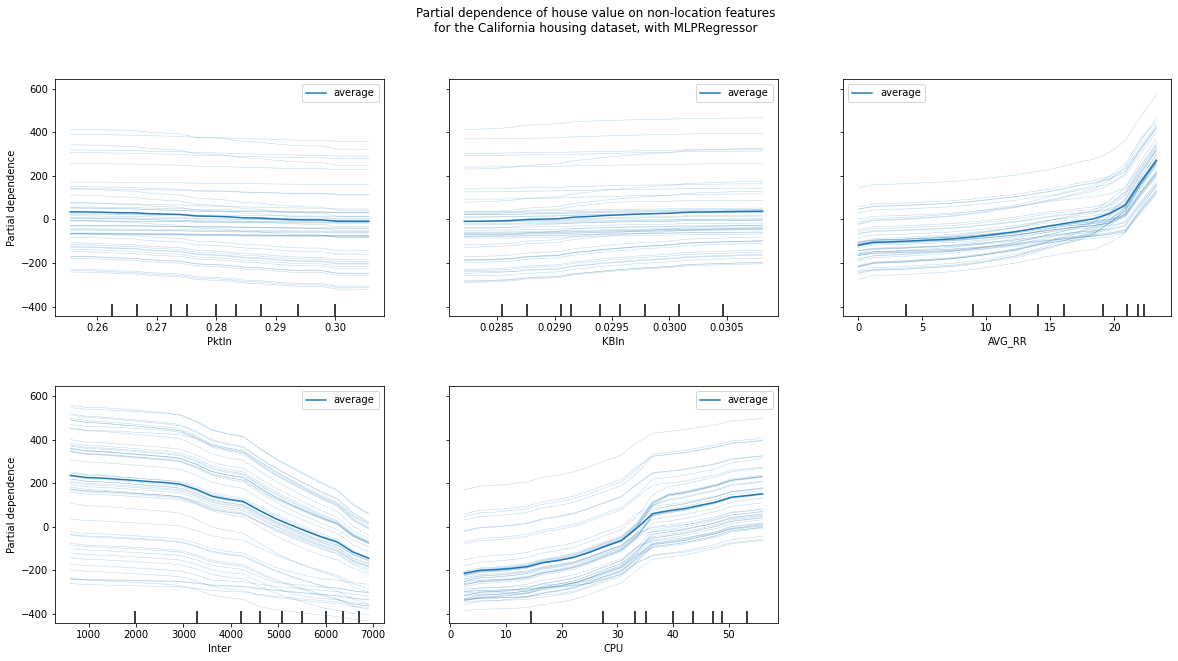

In [18]:
import matplotlib.pyplot as plt
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence

plt.rcParams["figure.figsize"] = (20, 10)

print('Computing partial dependence plots...')
tic = time()
features = ['PktIn', 'KBIn', 'AVG_RR', 'Inter', 'CPU']
display = plot_partial_dependence(
       est, X_train, features, kind="both", subsample=50,
       n_jobs=3, grid_resolution=20, random_state=0
)
print(f"done in {time() - tic:.3f}s")
display.figure_.suptitle(
    'Partial dependence of house value on non-location features\n'
    'for the California housing dataset, with MLPRegressor'
)
display.figure_
display.figure_.subplots_adjust(hspace=0.3)

Computing partial dependence plots...
done in 0.739s


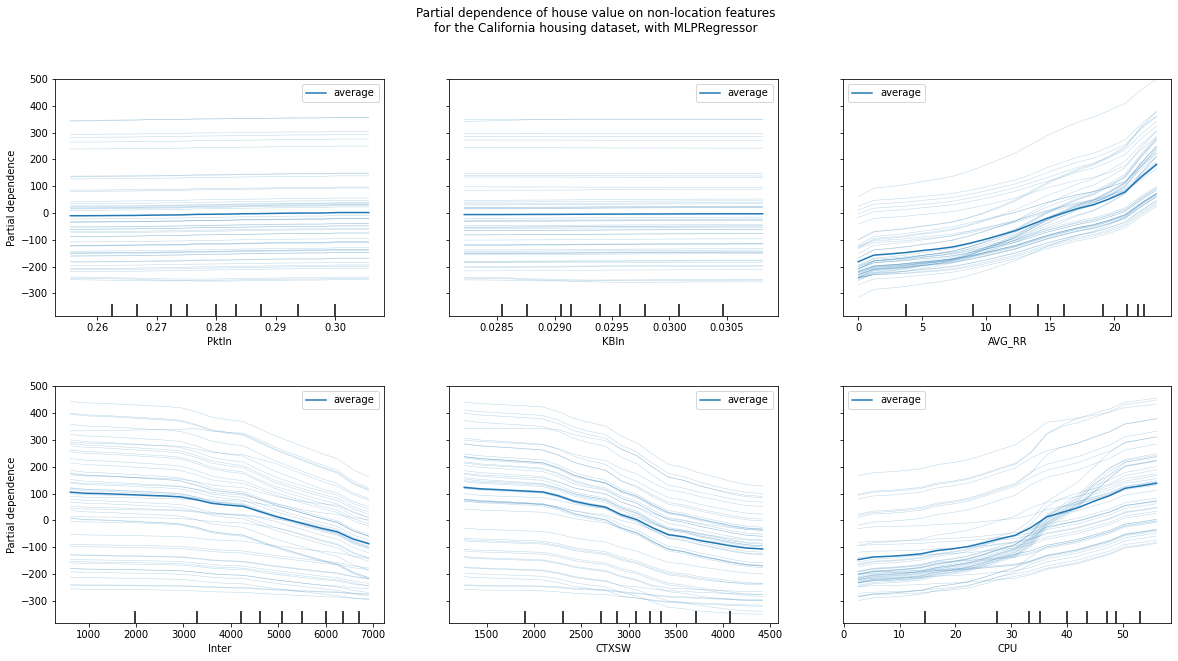

In [35]:
import matplotlib.pyplot as plt
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence

plt.rcParams["figure.figsize"] = (20, 10)

print('Computing partial dependence plots...')
tic = time()
features = ['PktIn', 'KBIn', 'AVG_RR', 'Inter', 'CTXSW', 'CPU']
display = plot_partial_dependence(
       est, X_train, features, kind="both", subsample=50,
       n_jobs=3, grid_resolution=20, random_state=0
)
print(f"done in {time() - tic:.3f}s")
display.figure_.suptitle(
    'Partial dependence of house value on non-location features\n'
    'for the California housing dataset, with MLPRegressor'
)
display.figure_
display.figure_.subplots_adjust(hspace=0.3)

# Gradient boosting

Let’s now fit a [HistGradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html) and compute the partial dependence on the same features.

In [36]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor

print("Training HistGradientBoostingRegressor...")
tic = time()
est = HistGradientBoostingRegressor()
est.fit(X_train, y_train)
print(f"done in {time() - tic:.3f}s")
print(f"Test R2 score: {est.score(X_test, y_test):.2f}")

Training HistGradientBoostingRegressor...
done in 0.340s
Test R2 score: 0.82


Here, we used the default hyperparameters for the gradient boosting model without any preprocessing as tree-based models are naturally robust to monotonic transformations of numerical features.

Note that on this tabular dataset, Gradient Boosting Machines are both significantly faster to train and more accurate than neural networks. It is also significantly cheaper to tune their hyperparameters (the defaults tend to work well while this is not often the case for neural networks).

We will plot the partial dependence, both individual (ICE) and averaged one (PDP). We limit to only 50 ICE curves to not overcrowd the plot.

Computing partial dependence plots...
done in 1.333s


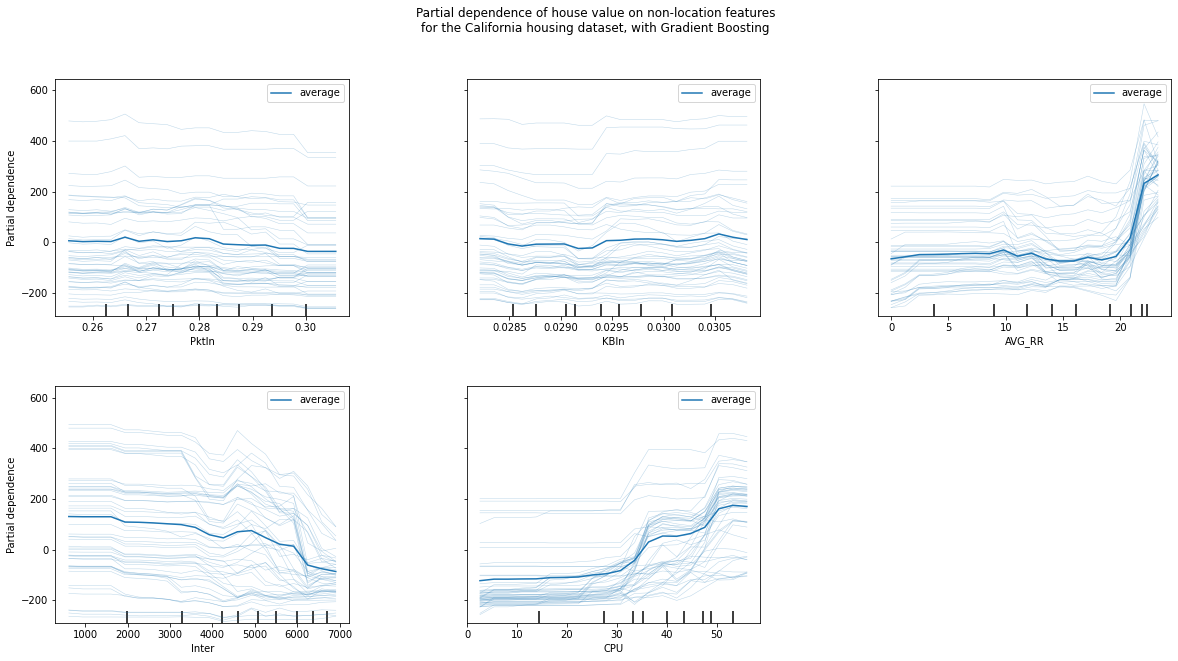

In [20]:
print('Computing partial dependence plots...')
tic = time()
display = plot_partial_dependence(
    est, X_train, features, kind="both", subsample=50,
    n_jobs=3, grid_resolution=20, random_state=0
)
print(f"done in {time() - tic:.3f}s")
display.figure_.suptitle(
    'Partial dependence of house value on non-location features\n'
    'for the California housing dataset, with Gradient Boosting'
)
display.figure_.subplots_adjust(wspace=0.4, hspace=0.3)

Computing partial dependence plots...
done in 1.726s


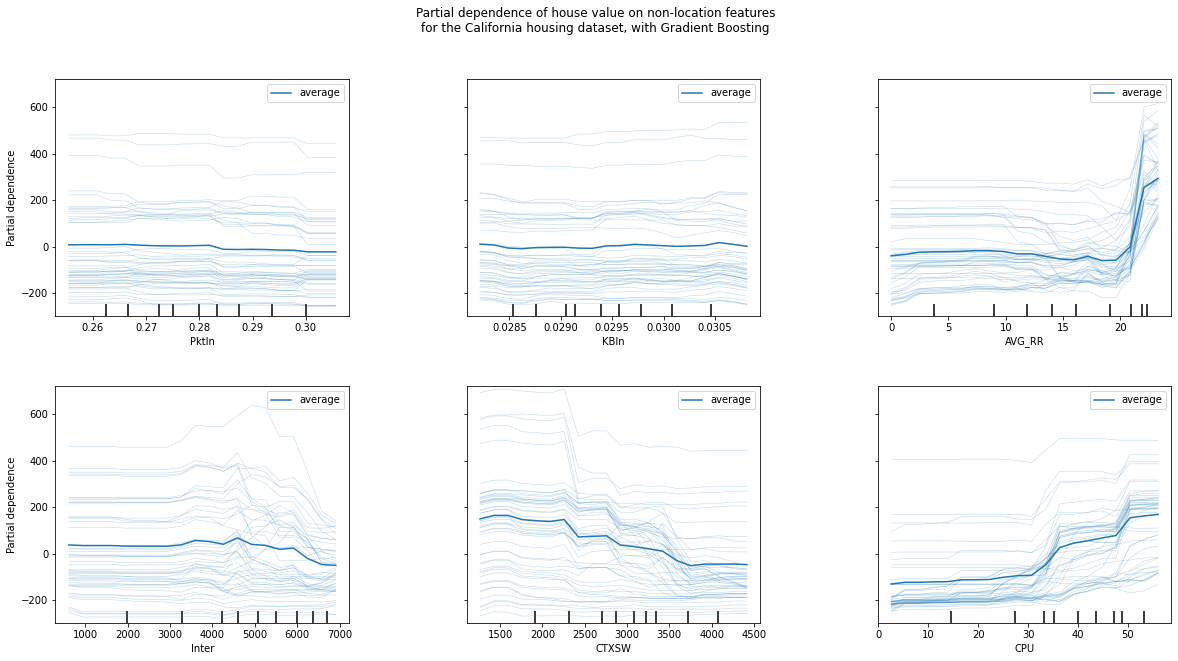

In [37]:
print('Computing partial dependence plots...')
tic = time()
display = plot_partial_dependence(
    est, X_train, features, kind="both", subsample=50,
    n_jobs=3, grid_resolution=20, random_state=0
)
print(f"done in {time() - tic:.3f}s")
display.figure_.suptitle(
    'Partial dependence of house value on non-location features\n'
    'for the California housing dataset, with Gradient Boosting'
)
display.figure_.subplots_adjust(wspace=0.4, hspace=0.3)

# Analysis of the plots

We can clearly see on the PDPs (thick blue line) that the median house price shows a linear relationship with the median income (top left) and that the house price drops when the average occupants per household increases (top middle). The top right plot shows that the house age in a district does not have a strong influence on the (median) house price; so does the average rooms per household.

The ICE curves (light blue lines) complement the analysis: we can see that there are some exceptions, where the house price remain constant with median income and average occupants. On the other hand, while the house age (top right) does not have a strong influence on the median house price on average, there seems to be a number of exceptions where the house price increase when between the ages 15-25. Similar exceptions can be observed for the average number of rooms (bottom left). Therefore, ICE plots show some individual effect which are attenuated by taking the averages.

In all plots, the tick marks on the x-axis represent the deciles of the feature values in the training data.

We also observe that [MLPRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html) has much smoother predictions than [HistGradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html).

However, it is worth noting that we are creating potential meaningless synthetic samples if features are correlated.

# 2D interaction plots

PDPs with two features of interest enable us to visualize interactions among them. However, ICEs cannot be plotted in an easy manner and thus interpreted. Another consideration is linked to the performance to compute the PDPs. With the tree-based algorithm, when only PDPs are requested, they can be computed on an efficient way using the `'recursion'` method.

Computing partial dependence plots...
done in 0.183s


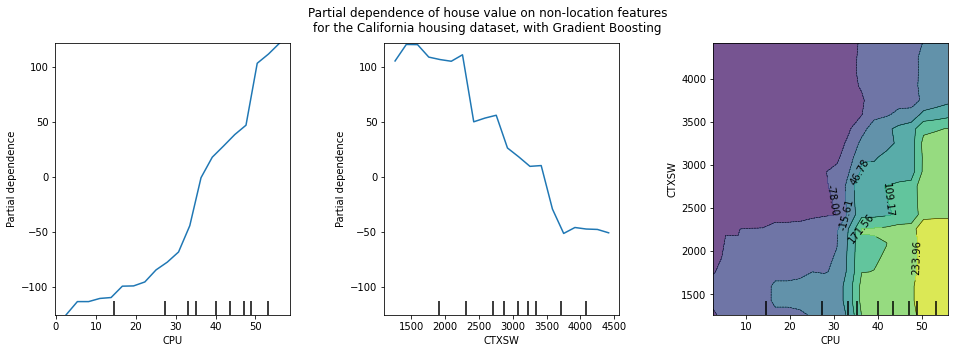

In [39]:

# features = ['PktIn', 'KBIn', 'AVG_RR', 'Inter', 'CTXSW', 'CPU']
features = ['CPU', 'CTXSW', ('CPU', 'CTXSW')]

print('Computing partial dependence plots...')
tic = time()
_, ax = plt.subplots(ncols=3, figsize=(16, 5))
display = plot_partial_dependence(
    est, X_train, features, kind='average', n_jobs=3, grid_resolution=20,
    ax=ax,
)
print(f"done in {time() - tic:.3f}s")
display.figure_.suptitle(
    'Partial dependence of house value on non-location features\n'
    'for the California housing dataset, with Gradient Boosting'
)
display.figure_.subplots_adjust(wspace=0.4, hspace=0.3)

The two-way partial dependence plot shows the dependence of median house price on joint values of house age and average occupants per household. We can clearly see an interaction between the two features: for an average occupancy greater than two, the house price is nearly independent of the house age, whereas for values less than two there is a strong dependence on age.

# 3D interaction plots

Let’s make the same partial dependence plot for the 2 features interaction, this time in 3 dimensions.

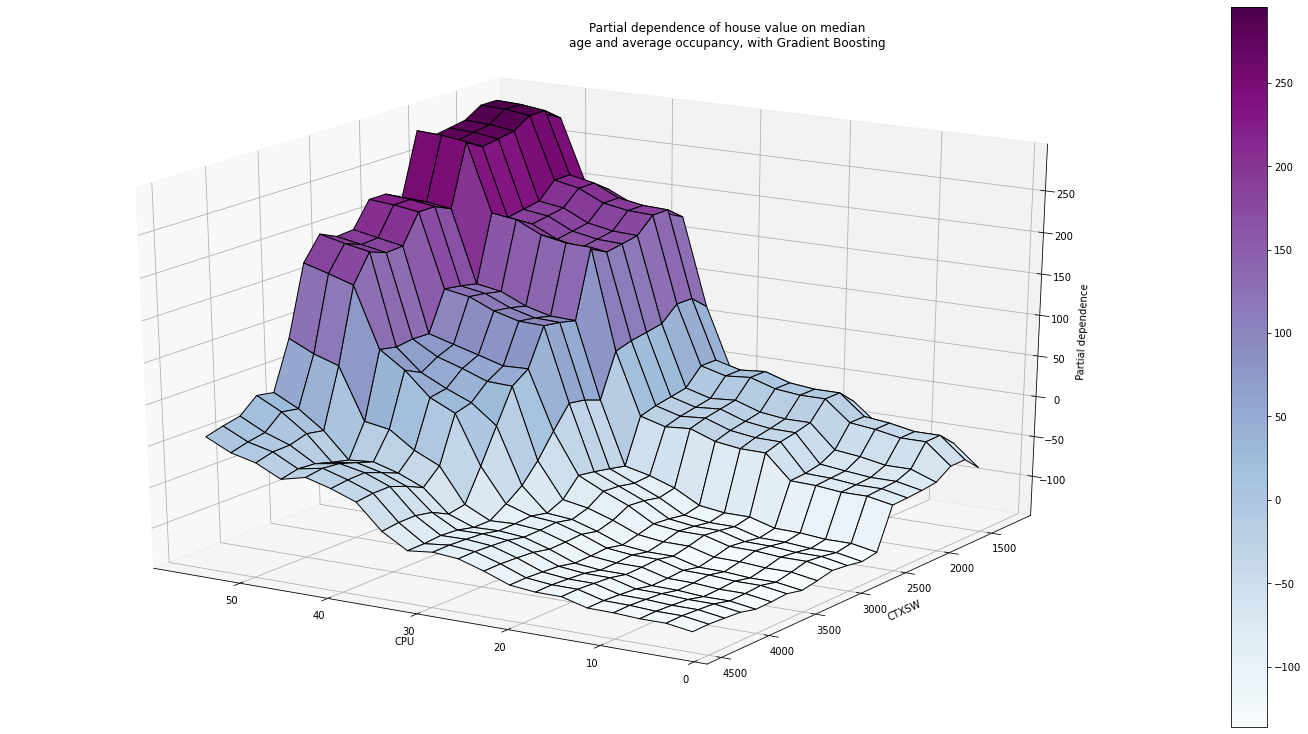

In [40]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()

features = ('CPU', 'CTXSW')
pdp = partial_dependence(
    est, X_train, features=features, kind='average', grid_resolution=20
)
XX, YY = np.meshgrid(pdp["values"][0], pdp["values"][1])
Z = pdp.average[0].T
ax = Axes3D(fig)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1,
                       cmap=plt.cm.BuPu, edgecolor='k')
ax.set_xlabel(features[0])
ax.set_ylabel(features[1])
ax.set_zlabel('Partial dependence')
# pretty init view
ax.view_init(elev=22, azim=122)
plt.colorbar(surf)
plt.suptitle('Partial dependence of house value on median\n'
             'age and average occupancy, with Gradient Boosting')
plt.subplots_adjust(top=0.9)
plt.show()